<a href="https://colab.research.google.com/github/PedroHenriqueS22/Praticas_Analise_Dados_DNC/blob/main/Previs%C3%A3o_usu%C3%A1rios_com_alta_chance_de_deixar_seu_Streaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preveja os usuários com alta chance de deixar seu Streaming

## Contexto

Você trabalha em uma plataforma de streaming e a diretoria está preocupada com o
alto índice de usuários cancelando as suas assinaturas. Eles acreditam que é possível prever se um usuário tem mais chance de deixar a plataforma antes que isso aconteça, e com base nessa informação tomar ações para reduzir o churn.
Seu objetivo é criar um modelo de classificação capaz de prever se um usuário tem mais chance de cancelar a sua assinatura na plataforma ou não. Para isso, a empresa forneceu uma base de dados em csv contendo dados sobre as contas dos clientes.

## Etapas:

* Data Understanding
* Data Preparation
* Modelling - Logistic Regression
* Tunning - Logistic Regression
* Modelling - Random Forest
* Tunning - Random Forest




In [ ]:
!pip install scikit-learn

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
pip install missingno

Importando todas as bibliotecas necessárias:

In [634]:
import pandas as pd
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [635]:
# DataFrame

df = pd.read_csv('/content/streaming_data.csv')

# Visualizando as primeiras 5 linhas da base de dados

df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


## 1. Data Understanding

Gerando as estatísticas descritivas dos dados:

In [636]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,66607.0,43.511072,15.043158,18.0,30.00,43.00,57.0,69.0
Time_on_platform,56464.0,4385.848505,2526.580859,0.0,2196.00,4384.00,6573.0,8759.0
Devices_connected,52696.0,2.995370,1.414072,1.0,2.00,3.00,4.0,5.0
Num_streaming_services,9572.0,2.496239,1.120700,1.0,1.00,2.00,4.0,4.0
Num_active_profiles,77884.0,3.002273,1.413235,1.0,2.00,3.00,4.0,5.0
Avg_rating,60614.0,3.002252,1.154963,1.0,1.99,3.01,4.0,5.0
Churned,61148.0,0.243066,0.428938,0.0,0.00,0.00,0.0,1.0


Verificando a presença de dados nulos e os tipos de variáveis presentes na base de dados:

In [637]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


In [638]:
df.isnull().any()

,0
Age,True
Gender,True
Time_on_platform,True
Devices_connected,True
Subscription_type,True
Num_streaming_services,True
Num_active_profiles,False
Avg_rating,True
Churned,True
User_id,False


In [639]:
df.isna().sum()

,0
Age,11277
Gender,14516
Time_on_platform,21420
Devices_connected,25188
Subscription_type,25221
Num_streaming_services,68312
Num_active_profiles,0
Avg_rating,17270
Churned,16736
User_id,0


Identificando e mostrando valores nulos em porcentagem:

In [640]:
df_missing = (
  df.isna().sum()
  .to_frame('missing_count')
  .join((df.isna().sum() / df.shape[0]).to_frame('missing_pct'))
  .sort_values('missing_count', ascending=False)
)

df_missing.style.format('{:.2%}', subset=['missing_pct'])

,missing_count,missing_pct
Num_streaming_services,68312,87.71%
Subscription_type,25221,32.38%
Devices_connected,25188,32.34%
Time_on_platform,21420,27.50%
Avg_rating,17270,22.17%
Churned,16736,21.49%
Gender,14516,18.64%
Age,11277,14.48%
Num_active_profiles,0,0.00%
User_id,0,0.00%


Plotando a matrix para melhor visualização das colunas com valores nulos:

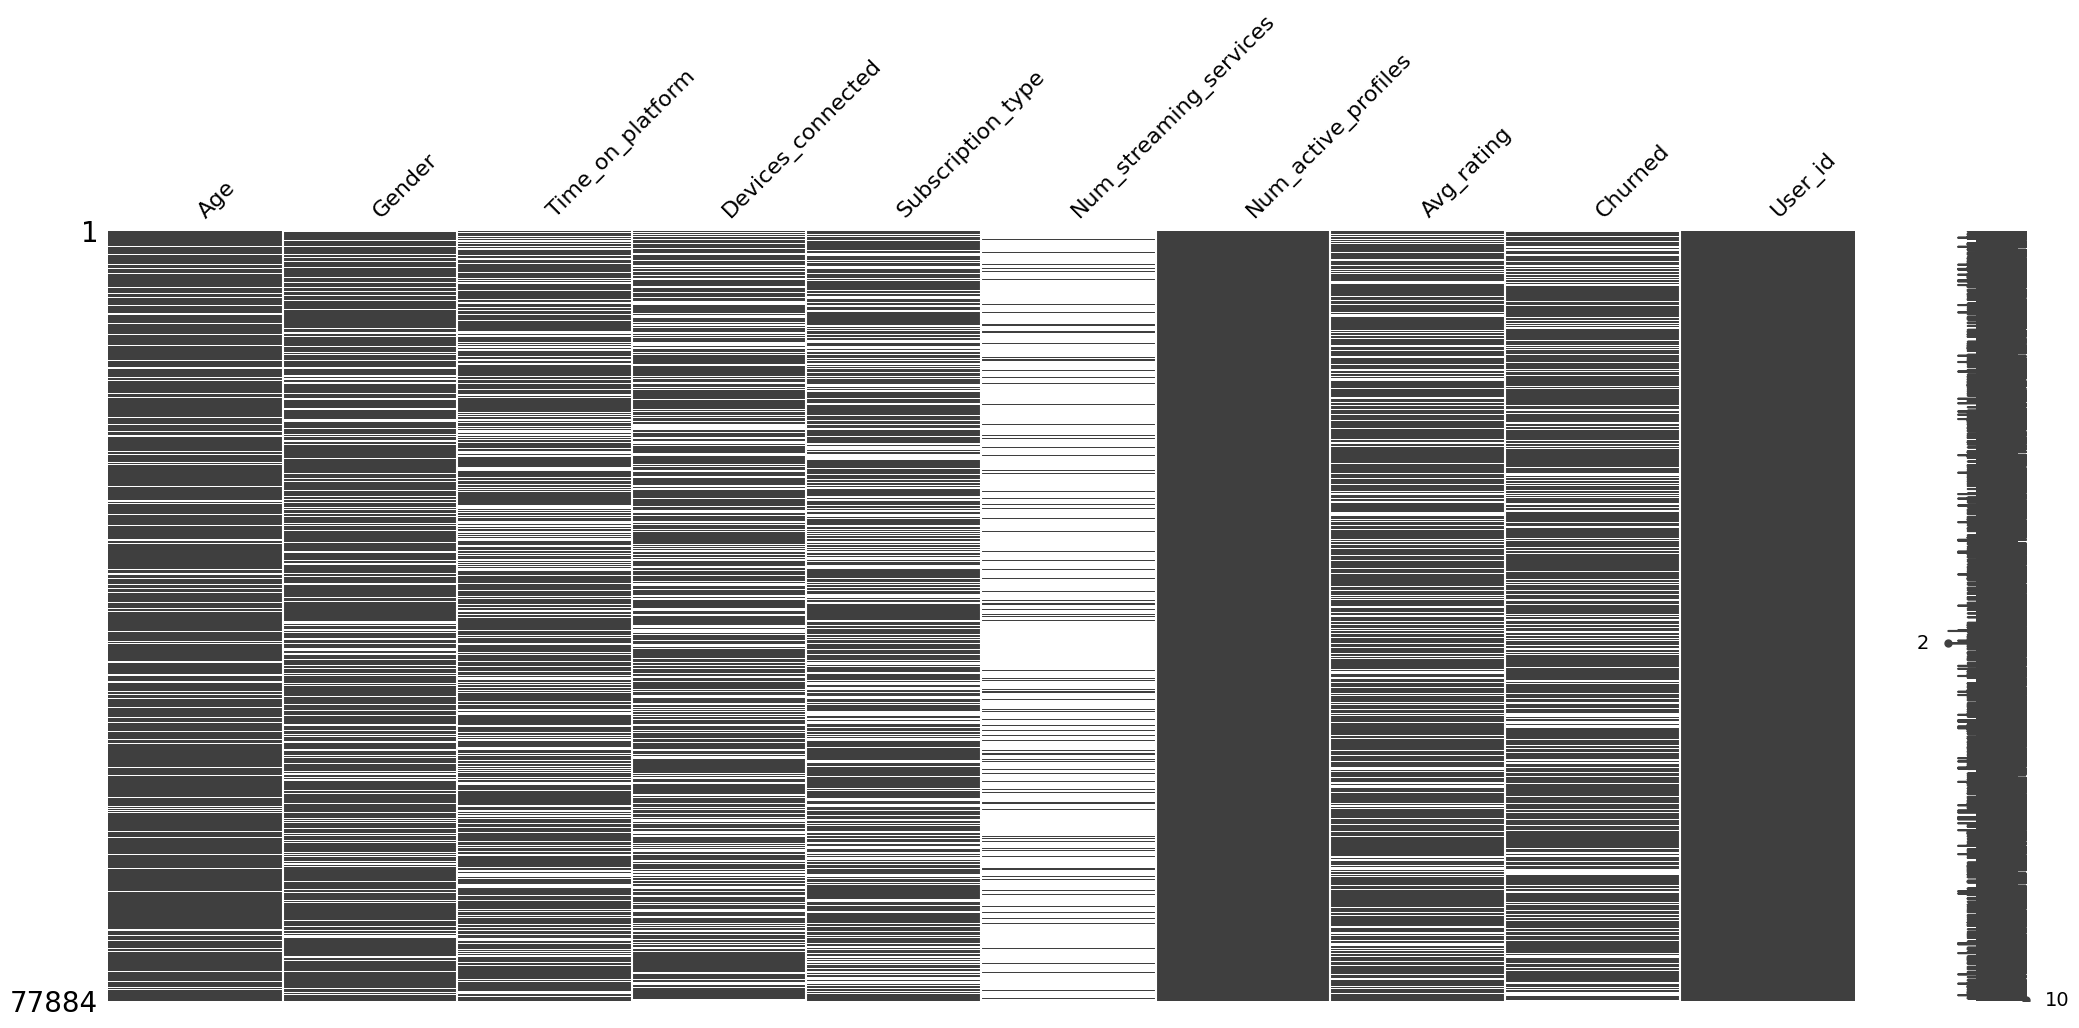

In [641]:
msno.matrix(df);

Gerando alguns gráficos para melhor entedimento:

In [642]:
# Verificando a quantidade de id pelo gênero

Gender = df.groupby('Gender')['User_id'].count().reset_index()
Gender = pd.DataFrame(Gender)
Gender

,Gender,User_id
0,Female,31572
1,Male,31796


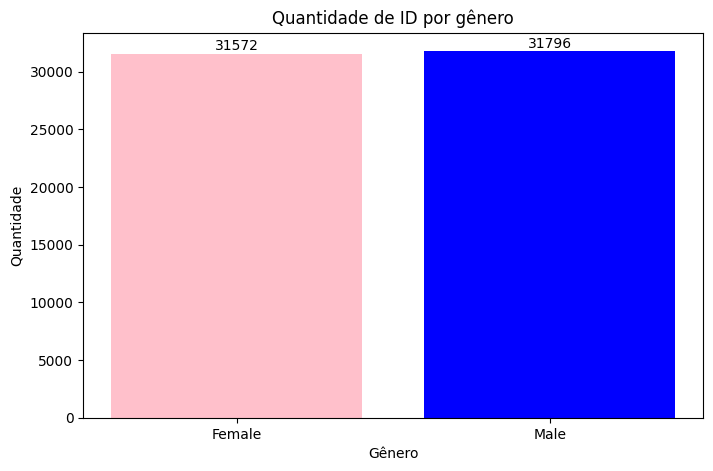

In [643]:
# Plotando o gráfico para visualizar a quantidade de id por gênero

plt.figure(figsize=(8, 5))
plt.bar(Gender['Gender'], Gender['User_id'], color=['pink', 'blue'])

for i, value in enumerate(Gender['User_id']):
    plt.text(Gender['Gender'][i], value + 300, str(value), ha='center')

plt.xlabel('Gênero')
plt.ylabel('Quantidade')
plt.title('Quantidade de ID por gênero')
plt.show()

In [644]:
# Verificando a quantidade de id pelo tipo de assinatura

Subscription_type = df.groupby('Subscription_type')['User_id'].count().reset_index()
Subscription_type = pd.DataFrame(Subscription_type)
Subscription_type

,Subscription_type,User_id
0,Basic,17527
1,Premium,17625
2,Standard,17511


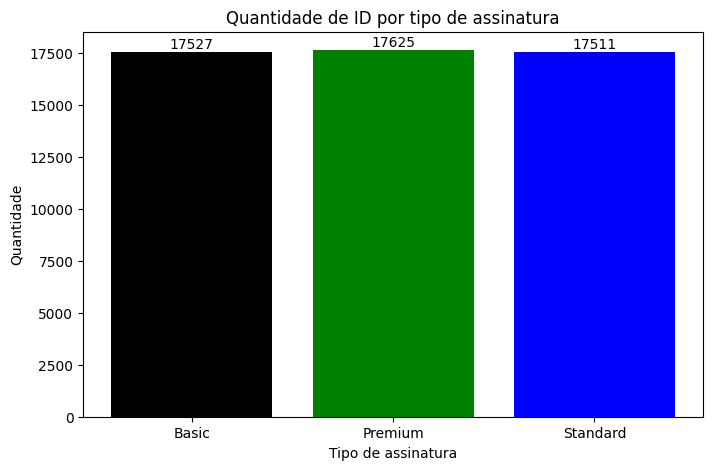

In [645]:
# Plotando o gráfico para visualizar a quantidade de id por tipo de assinatura

plt.figure(figsize=(8, 5))
plt.bar(Subscription_type['Subscription_type'], Subscription_type['User_id'], color=['black', 'green', 'blue'])

for i, value in enumerate(Subscription_type['User_id']):
    plt.text(Subscription_type['Subscription_type'][i], value + 200, str(value), ha='center')

plt.xlabel('Tipo de assinatura')
plt.ylabel('Quantidade')
plt.title('Quantidade de ID por tipo de assinatura')
plt.show()

* Percebe-se que a quantidade de ID por tipo de assinatura e por gênero é bem equilibrado;





In [646]:
# Verificando a quantidade de churned

Churned = df.groupby('Churned')['User_id'].count().reset_index()
Churned = pd.DataFrame(Churned)
Churned

,Churned,User_id
0,0.0,46285
1,1.0,14863


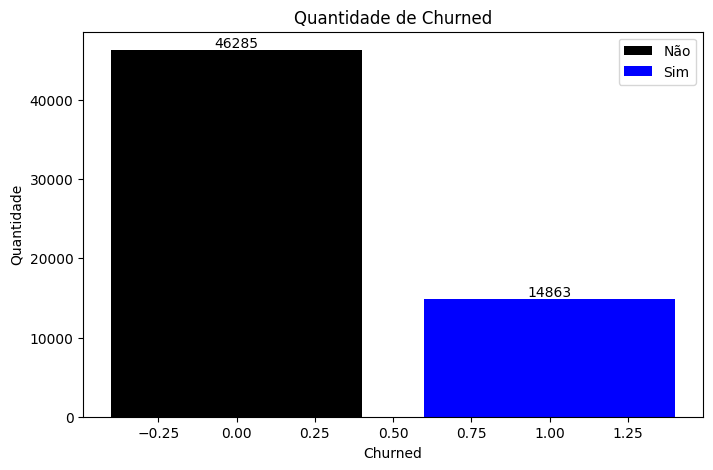

In [647]:
# Plotando o gráfico para visualizar a quantidade de churned

plt.figure(figsize=(8, 5))
fig = plt.bar(Churned['Churned'], Churned['User_id'], color=['black', 'blue'])

for i, value in enumerate(Churned['User_id']):
    plt.text(Churned['Churned'][i], value + 300, str(value), ha='center')

plt.xlabel('Churned')
plt.ylabel('Quantidade')
plt.title('Quantidade de Churned')
plt.legend(fig, ['Não', 'Sim'])
plt.show()

In [648]:
# Verificando a quantidade de churned pelo tipo de assinatura

Churned_Subscription_type = df.groupby(['Churned','Subscription_type'])['User_id'].count().reset_index()
Churned_Subscription_type = pd.DataFrame(Churned_Subscription_type)
Churned_Subscription_type

,Churned,Subscription_type,User_id
0,0.0,Basic,10421
1,0.0,Premium,10457
2,0.0,Standard,10487
3,1.0,Basic,3396
4,1.0,Premium,3358
5,1.0,Standard,3331


## 2. Data Preparation

Substituindo valores “NaN” por 0 Colunas nas colunas Time_on_platform,Num_streaming_services, Churned, Avg_rating, Devices_connected:

In [649]:
df_NaN = ['Time_on_platform', 'Num_streaming_services', 'Churned', 'Avg_rating', 'Devices_connected']
df[df_NaN] = df[df_NaN].fillna(0)

In [650]:
# Verificando se o passo anterior foi feito corretamente

df.isna().sum()

,0
Age,11277
Gender,14516
Time_on_platform,0
Devices_connected,0
Subscription_type,25221
Num_streaming_services,0
Num_active_profiles,0
Avg_rating,0
Churned,0
User_id,0


Dropando linhas nulas nas colunas Gender, Subscription_type e Age:

In [651]:
df = df.dropna(subset=['Gender', 'Subscription_type', 'Age'])

In [652]:
# Verificando se o passo anterior foi feito corretamente

df.isna().sum()

,0
Age,0
Gender,0
Time_on_platform,0
Devices_connected,0
Subscription_type,0
Num_streaming_services,0
Num_active_profiles,0
Avg_rating,0
Churned,0
User_id,0


Transformando valores churned 0 e 1 por No e Yes:

In [653]:
df['Churned'] = df['Churned'].replace({0: 'No', 1: 'Yes'})

<ipython-input-653-e2638a3c07ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Churned'] = df['Churned'].replace({0: 'No', 1: 'Yes'})


In [654]:
# Verificando o passo anterior

Churned = df.groupby('Churned')['User_id'].count().reset_index()
Churned

,Churned,User_id
0,No,29459
1,Yes,7056


Transformando valores floats em valores inteiros:

In [655]:
df = df.astype({'Age': 'int',	'Time_on_platform': 'int', 'Devices_connected': 'int', 'Num_streaming_services': 'int'})

# Verificando se foi convertido corretamente

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36515 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     36515 non-null  int64  
 1   Gender                  36515 non-null  object 
 2   Time_on_platform        36515 non-null  int64  
 3   Devices_connected       36515 non-null  int64  
 4   Subscription_type       36515 non-null  object 
 5   Num_streaming_services  36515 non-null  int64  
 6   Num_active_profiles     36515 non-null  int64  
 7   Avg_rating              36515 non-null  float64
 8   Churned                 36515 non-null  object 
 9   User_id                 36515 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 3.1+ MB


* A coluna Avg_rating foi mantinda como float, visto que se tratava de fato de valores decimais




## 3. Data modeling

Definindo as variáveis X e y para o modelo:

In [656]:
X = df.drop(columns=['Churned', 'User_id'], axis=1)

y = df[['Churned']]

Preparando y com LabelEncoder:

In [657]:
le = LabelEncoder()

le.fit(y)
y = le.transform(y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Convertendo as variáveis ​​categóricas em variáveis ​​fictícias/indicadoras:

In [658]:
X = pd.get_dummies(X)

Padronizando os dados:

In [659]:
# Instanciar um objeto de escala Min-Max
mm = MinMaxScaler()

# Ajustar e transformar nossos dados de recursos em um dataframe do pandas

X = pd.DataFrame(mm.fit_transform(X))

Separando a base de treino e teste:

In [660]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

## 3.1. Logistic Regression

Treinando o modelo:

In [661]:
model_lr = LogisticRegression()
lr = model_lr.fit(X_train, y_train)

Fazendo a predição:

In [662]:
lr.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [663]:
X_test.assign(churn = y_test).assign(label = lr.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,10,churn,label
1067,0.686275,0.884918,0.0,0.0,0.75,0.342,1.0,0.0,0.0,1.0,0.0,0,0
33463,0.215686,0.452677,0.4,0.0,0.50,0.468,1.0,0.0,1.0,0.0,0.0,0,0
1582,0.137255,0.168855,0.6,0.0,0.25,0.658,0.0,1.0,0.0,0.0,1.0,0,0
32104,0.705882,0.389999,0.2,0.0,0.00,0.974,1.0,0.0,0.0,0.0,1.0,0,0
7056,0.372549,0.960840,0.6,0.0,0.75,0.540,1.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23178,0.803922,0.920996,0.2,0.0,0.50,0.714,0.0,1.0,0.0,1.0,0.0,1,0
15631,0.450980,0.000000,1.0,0.0,0.50,0.680,0.0,1.0,0.0,1.0,0.0,1,0
3166,0.901961,0.000000,0.8,0.0,0.25,0.664,0.0,1.0,0.0,1.0,0.0,0,0
9635,0.019608,0.360543,0.0,0.0,0.75,0.642,0.0,1.0,0.0,1.0,0.0,0,0


Plotando matrix confusão:

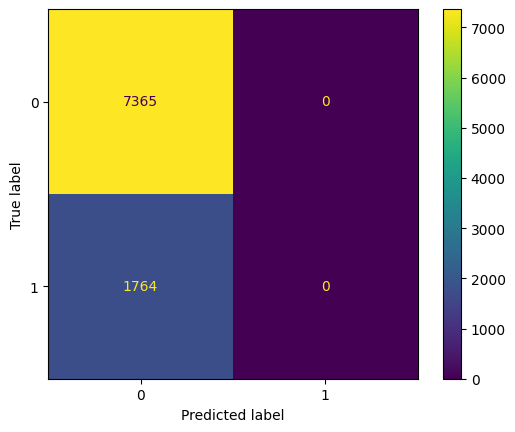

In [664]:
# Calcula a matriz de confusão
cm = confusion_matrix(y_test, lr.predict(X_test))

# Exibe a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')

Printando as métricas:

In [665]:
print(f"Acurácia (Treino): {accuracy_score(y_train, lr.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, lr.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, lr.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, lr.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, lr.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.8067625794201416
Acurácia (Teste): 0.8067696352283931
Acurácia Balanceada (Treino): 0.5
Acurácia Balanceada (Teste): 0.5
Precision (Treino): 0.0
Precision (Teste): 0.0
Recall (Treino): 0.0
Recall (Teste): 0.0
F1-Score (Treino): 0.0
F1-Score (Teste): 0.0
ROCAUC (Treino): 0.5149524961408278
ROCAUC (Teste): 0.4873733245278198


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Tunning of Logistic Regression

Definindo os parâmetros para o GridSearch:

In [666]:
parameters = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 300]
}

grid_search = GridSearchCV(model_lr, parameters, scoring='accuracy', cv=5, n_jobs=-1)

Utilizando o GridSearch para encontrar os melhores parâmetros:

In [667]:
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

In [668]:
grid_search.best_estimator_.get_params()

{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Criando modelo com os melhores parâmetros, treinando, plotando a matriz de confusão e as métricas:

In [669]:
lr_tunned = LogisticRegression(
 C= 0.01,
 class_weight= None,
 dual= False,
 fit_intercept= True,
 intercept_scaling= 1,
 l1_ratio= None,
 max_iter= 100,
 multi_class= 'deprecated',
 n_jobs= None,
 penalty= 'l2',
 random_state= None,
 solver= 'liblinear',
 tol= 0.0001,
 verbose= 0,
 warm_start= False
)

In [670]:
lr_tunned.fit(X, y)

LogisticRegression(C=0.01, solver='liblinear')

In [671]:
lr_tunned.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [672]:
X_test.assign(churn = y_test).assign(label = lr_tunned.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,10,churn,label
1067,0.686275,0.884918,0.0,0.0,0.75,0.342,1.0,0.0,0.0,1.0,0.0,0,0
33463,0.215686,0.452677,0.4,0.0,0.50,0.468,1.0,0.0,1.0,0.0,0.0,0,0
1582,0.137255,0.168855,0.6,0.0,0.25,0.658,0.0,1.0,0.0,0.0,1.0,0,0
32104,0.705882,0.389999,0.2,0.0,0.00,0.974,1.0,0.0,0.0,0.0,1.0,0,0
7056,0.372549,0.960840,0.6,0.0,0.75,0.540,1.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23178,0.803922,0.920996,0.2,0.0,0.50,0.714,0.0,1.0,0.0,1.0,0.0,1,0
15631,0.450980,0.000000,1.0,0.0,0.50,0.680,0.0,1.0,0.0,1.0,0.0,1,0
3166,0.901961,0.000000,0.8,0.0,0.25,0.664,0.0,1.0,0.0,1.0,0.0,0,0
9635,0.019608,0.360543,0.0,0.0,0.75,0.642,0.0,1.0,0.0,1.0,0.0,0,0


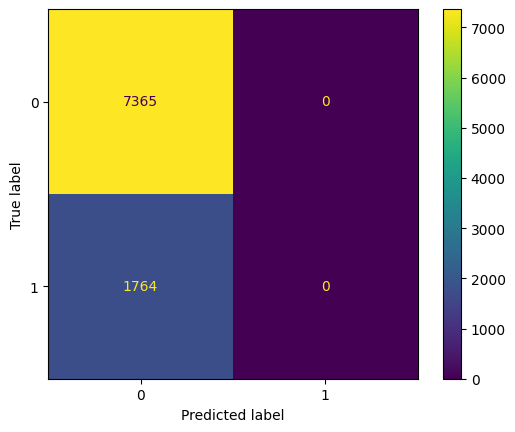

In [673]:
# Calcula a matriz de confusão
cm = confusion_matrix(y_test, lr_tunned.predict(X_test))

# Exibe a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')

In [674]:
print(f"Acurácia (Treino): {accuracy_score(y_train, lr_tunned.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, lr_tunned.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, lr_tunned.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, lr_tunned.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, lr_tunned.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, lr_tunned.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, lr_tunned.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, lr_tunned.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, lr_tunned.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, lr_tunned.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, lr_tunned.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, lr_tunned.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.8067625794201416
Acurácia (Teste): 0.8067696352283931
Acurácia Balanceada (Treino): 0.5
Acurácia Balanceada (Teste): 0.5
Precision (Treino): 0.0
Precision (Teste): 0.0
Recall (Treino): 0.0
Recall (Teste): 0.0
F1-Score (Treino): 0.0
F1-Score (Teste): 0.0
ROCAUC (Treino): 0.5031043876569166
ROCAUC (Teste): 0.5205325488421211


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 3.2 Random Forest

Seguindo os passos agora para utilização do modelo Random Forest. Criando o modelo, treinando, fazendo sua predição, plotando a matriz de confusão e as métricas:

In [675]:
rf =  RandomForestClassifier()

In [676]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [677]:
rf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [678]:
X_test.assign(churn = y_test).assign(label = rf.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,10,churn,label
1067,0.686275,0.884918,0.0,0.0,0.75,0.342,1.0,0.0,0.0,1.0,0.0,0,0
33463,0.215686,0.452677,0.4,0.0,0.50,0.468,1.0,0.0,1.0,0.0,0.0,0,0
1582,0.137255,0.168855,0.6,0.0,0.25,0.658,0.0,1.0,0.0,0.0,1.0,0,0
32104,0.705882,0.389999,0.2,0.0,0.00,0.974,1.0,0.0,0.0,0.0,1.0,0,0
7056,0.372549,0.960840,0.6,0.0,0.75,0.540,1.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23178,0.803922,0.920996,0.2,0.0,0.50,0.714,0.0,1.0,0.0,1.0,0.0,1,0
15631,0.450980,0.000000,1.0,0.0,0.50,0.680,0.0,1.0,0.0,1.0,0.0,1,0
3166,0.901961,0.000000,0.8,0.0,0.25,0.664,0.0,1.0,0.0,1.0,0.0,0,0
9635,0.019608,0.360543,0.0,0.0,0.75,0.642,0.0,1.0,0.0,1.0,0.0,0,0


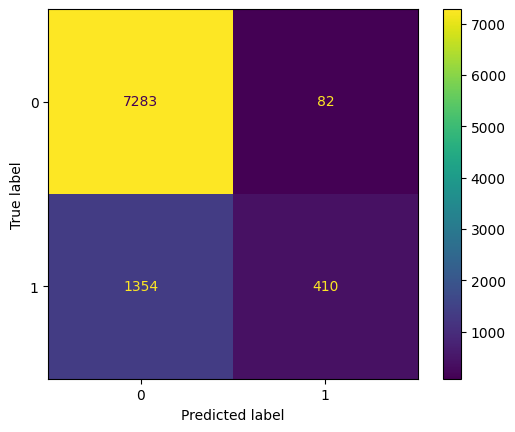

In [679]:
# Calcula a matriz de confusão
cm = confusion_matrix(y_test, rf.predict(X_test))

# Exibe a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')

In [680]:
print(f"Acurácia (Treino): {accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.9982837946395968
Acurácia (Teste): 0.8426990908095081
Acurácia Balanceada (Treino): 0.9963497030929689
Acurácia Balanceada (Teste): 0.6106462815947832
Precision (Treino): 0.9979115245870515
Precision (Teste): 0.8333333333333334
Recall (Treino): 0.9931972789115646
Recall (Teste): 0.23242630385487528
F1-Score (Treino): 0.9955488209110711
F1-Score (Teste): 0.36347517730496454
ROCAUC (Treino): 0.9999389975054019
ROCAUC (Teste): 0.6816639418836103


### Tunning of Random Forest

Definindo os parâmetros para o GridSearch:

In [681]:
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'n_estimators': [100, 300, 500]}

grid_search = GridSearchCV(rf, parameters, scoring='accuracy', cv=5, n_jobs=-1)

Utilizando o GridSearch para encontrar os melhores parâmetros:

In [682]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [683]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Criando modelo com os melhores parâmetros, treinando, plotando a matriz de confusão e as métricas:

In [684]:
rf_tunned =  RandomForestClassifier(bootstrap = True, ccp_alpha = 0.0,
                                     class_weight = None, criterion= 'gini',
                                     max_depth = 1, max_features= 'sqrt',
                                     max_leaf_nodes = None,
                                     max_samples = None,
                                     min_impurity_decrease = 0.0,
                                     min_samples_leaf = 1,
                                     min_samples_split = 2,
                                     min_weight_fraction_leaf = 0.0,
                                     monotonic_cst= None,
                                     n_estimators = 100, n_jobs = None,
                                     oob_score = False, random_state = None,
                                     verbose = 0, warm_start = False)
rf_tunned

RandomForestClassifier(max_depth=1)

In [685]:
rf_tunned.fit(X_train, y_train)

RandomForestClassifier(max_depth=1)

In [686]:
rf_tunned.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [687]:
X_test.assign(churn = y_test).assign(label = rf_tunned.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,10,churn,label
1067,0.686275,0.884918,0.0,0.0,0.75,0.342,1.0,0.0,0.0,1.0,0.0,0,0
33463,0.215686,0.452677,0.4,0.0,0.50,0.468,1.0,0.0,1.0,0.0,0.0,0,0
1582,0.137255,0.168855,0.6,0.0,0.25,0.658,0.0,1.0,0.0,0.0,1.0,0,0
32104,0.705882,0.389999,0.2,0.0,0.00,0.974,1.0,0.0,0.0,0.0,1.0,0,0
7056,0.372549,0.960840,0.6,0.0,0.75,0.540,1.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23178,0.803922,0.920996,0.2,0.0,0.50,0.714,0.0,1.0,0.0,1.0,0.0,1,0
15631,0.450980,0.000000,1.0,0.0,0.50,0.680,0.0,1.0,0.0,1.0,0.0,1,0
3166,0.901961,0.000000,0.8,0.0,0.25,0.664,0.0,1.0,0.0,1.0,0.0,0,0
9635,0.019608,0.360543,0.0,0.0,0.75,0.642,0.0,1.0,0.0,1.0,0.0,0,0


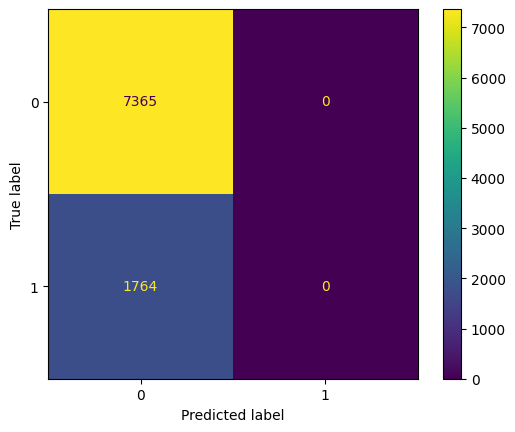

In [688]:
# Calcula a matriz de confusão
cm = confusion_matrix(y_test, rf_tunned.predict(X_test))

# Exibe a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')

In [689]:
print(f"Acurácia (Treino): {accuracy_score(y_train, rf_tunned.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf_tunned.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf_tunned.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf_tunned.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf_tunned.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf_tunned.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf_tunned.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.8067625794201416
Acurácia (Teste): 0.8067696352283931
Acurácia Balanceada (Treino): 0.5
Acurácia Balanceada (Teste): 0.5
Precision (Treino): 0.0
Precision (Teste): 0.0
Recall (Treino): 0.0
Recall (Teste): 0.0
F1-Score (Treino): 0.0
F1-Score (Teste): 0.0
ROCAUC (Treino): 0.5230463704144341
ROCAUC (Teste): 0.48920193105529153


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
